# Analysis for SSFA project: NewEplsar model
# Filtered strongly by < 20% NMP

## Table of contents
1. [Used packages](#imports)
1. [Global settings](#settings)
1. [Load data](#load)
1. [Explore data](#exp)
1. [Model specification](#model)
1. [Inference](#inference)
   1. [NewEplsar](#NewEplsar) 
1. [Summary](#summary)  

## Used packages <a name="imports"></a>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import pickle
import arviz as az
import pymc3 as pm

In [3]:
from matplotlib.colors import to_rgb

In [4]:
import scipy.stats as stats 

In [5]:
from IPython.display import display

In [6]:
import matplotlib as mpl

In [7]:
%load_ext autoreload
%autoreload 2

In [8]:
import plotting_lib

## Global settings <a name="settings"></a>

#### Output

In [9]:
writeOut = True
outPathPlots = "../plots/statistical_model_neweplsar_filter_weak/"
outPathData = "../derived_data/statistical_model_neweplsar_filter_weak/"

#### Plotting

In [10]:
widthMM = 190 
widthInch = widthMM / 25.4
ratio = 0.66666
heigthInch = ratio*widthInch

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
sns.set_style("ticks")

dpi = 300

In [11]:
sizes = [SMALL_SIZE,MEDIUM_SIZE,BIGGER_SIZE]

#### Computing

In [12]:
numSamples = 1000
numCores = 4
numTune = 1000
numPredSamples = 2000
random_seed=3651456135

## Load data <a name="load"></a>

In [13]:
datafile = "../derived_data/preprocessing/preprocessed_filter_weak.dat"

In [14]:
with open(datafile, "rb") as f:
    x1,x2,_,df,dataZ,dictMeanStd,dictTreatment,dictSoftware = pickle.load(f)    

Show that everything is correct:

In [15]:
display(pd.DataFrame.from_dict({'x1':x1,'x2':x2}))

x1  x2
0     0   5
1     1   5
2     0   5
3     1   5
4     0   5
..   ..  ..
273   1   9
274   0   9
275   1   9
276   0   9
277   1   9

[278 rows x 2 columns]

x1 indicates the software used, x2 indicates the treatment applied.

In [16]:
for surfaceParam,(mean,std) in dictMeanStd.items():
    print("Surface parameter {} has mean {} and standard deviation {}".format(surfaceParam,mean,std))

Surface parameter epLsar has mean 0.0032388209205305753 and standard deviation 0.0019378273835719989
Surface parameter Rsquared has mean 0.9974096825435252 and standard deviation 0.007283582118542012
Surface parameter Asfc has mean 14.919474245449283 and standard deviation 12.47068676838922
Surface parameter Smfc has mean 1.155270960424856 and standard deviation 7.13503174525663
Surface parameter HAsfc9 has mean 0.44593694325514915 and standard deviation 0.7912033512620836
Surface parameter HAsfc81 has mean 0.9300206156734742 and standard deviation 2.3638534390774013


In [17]:
for k,v in sorted(dictTreatment.items(), key=lambda x: x[0]):    
    print("Number {} encodes treatment {}".format(k,v))

Number 0 encodes treatment BrushDirt
Number 1 encodes treatment BrushNoDirt
Number 2 encodes treatment Clover
Number 3 encodes treatment Clover+dust
Number 4 encodes treatment Control
Number 5 encodes treatment Dry bamboo
Number 6 encodes treatment Dry grass
Number 7 encodes treatment Dry lucerne
Number 8 encodes treatment Grass
Number 9 encodes treatment Grass+dust
Number 10 encodes treatment RubDirt


In [18]:
for k,v in dictSoftware.items():
    print("Number {} encodes software {}".format(k,v))

Number 0 encodes software ConfoMap
Number 1 encodes software Toothfrax


In [19]:
display(dataZ)

index  TreatmentNumber  SoftwareNumber  DatasetNumber  NameNumber  \
0        0                5               0              0         115   
1        1                5               1              0         115   
2        2                5               0              0         116   
3        3                5               1              0         116   
4        4                5               0              0         117   
..     ...              ...             ...            ...         ...   
273    273                9               1              2          52   
274    274                9               0              2          53   
275    275                9               1              2          53   
276    276                9               0              2          54   
277    277                9               1              2          54   

     epLsar_z  Rsquared_z    Asfc_z    Smfc_z  HAsfc9_z  HAsfc81_z  
0    0.608031    0.081494 -0.261684 -0.120632 -0.391977  -0.239736  
1    0.764866    0.295228 -0.368764 -0.145206 -0.392397  -0.240365  
2    1.355641   -0.166422  0.043912 -0.120632 -0.346351  -0.268091  
3    1.350574    0.282460 -0.137943 -0.145206 -0.349727  -0.282929  
4    0.930308   -0.359987 -0.137793 -0.120632 -0.233444  -0.221925  
..        ...         ...       ...       ...       ...        ...  
273  0.611602    0.267769 -1.050437  0.035516  0.493708   0.076860  
274  0.084569    0.197735 -0.966638 -0.093723  0.242115   0.257597  
275 -0.051512    0.319804 -0.975181 -0.143224  0.644288   0.381453  
276 -1.041990    0.284041 -1.077552  0.011489 -0.095103  -0.053253  
277 -1.308590    0.336005 -1.081522 -0.104672 -0.126169  -0.038105  

[278 rows x 11 columns]

In [20]:
display(df)

Dataset                            Name   Software        Diet  \
0    GuineaPigs  capor_2CC6B1_txP4_#1_1_100xL_1   ConfoMap  Dry bamboo   
1    GuineaPigs  capor_2CC6B1_txP4_#1_1_100xL_1  Toothfrax  Dry bamboo   
2    GuineaPigs  capor_2CC6B1_txP4_#1_1_100xL_2   ConfoMap  Dry bamboo   
3    GuineaPigs  capor_2CC6B1_txP4_#1_1_100xL_2  Toothfrax  Dry bamboo   
4    GuineaPigs  capor_2CC6B1_txP4_#1_1_100xL_3   ConfoMap  Dry bamboo   
..          ...                             ...        ...         ...   
273      Sheeps          L8-Ovis-90730-lm2sin-a  Toothfrax  Grass+dust   
274      Sheeps          L8-Ovis-90764-lm2sin-a   ConfoMap  Grass+dust   
275      Sheeps          L8-Ovis-90764-lm2sin-a  Toothfrax  Grass+dust   
276      Sheeps          L8-Ovis-90814-lm2sin-a   ConfoMap  Grass+dust   
277      Sheeps          L8-Ovis-90814-lm2sin-a  Toothfrax  Grass+dust   

      Treatment Before.after       NMP NMP_cat    epLsar  Rsquared       Asfc  \
0    Dry bamboo          NaN  0.717312    0-5%  0.004417  0.998003  11.656095   
1    Dry bamboo          NaN  0.717312    0-5%  0.004721  0.999560  10.320730   
2    Dry bamboo          NaN  1.674215    0-5%  0.005866  0.996198  15.467083   
3    Dry bamboo          NaN  1.674215    0-5%  0.005856  0.999467  13.199232   
4    Dry bamboo          NaN  1.760409    0-5%  0.005042  0.994788  13.201101   
..          ...          ...       ...     ...       ...       ...        ...   
273  Grass+dust          NaN  0.000000    0-5%  0.004424  0.999360   1.819802   
274  Grass+dust          NaN  0.000000    0-5%  0.003403  0.998850   2.864831   
275  Grass+dust          NaN  0.000000    0-5%  0.003139  0.999739   2.758297   
276  Grass+dust          NaN  0.000000    0-5%  0.001220  0.999479   1.481662   
277  Grass+dust          NaN  0.000000    0-5%  0.000703  0.999857   1.432148   

         Smfc    HAsfc9   HAsfc81  NewEplsar  TreatmentNumber  SoftwareNumber  \
0    0.294557  0.135803  0.363319   0.019460                5               0   
1    0.119219  0.135471  0.361833        NaN                5               1   
2    0.294557  0.171903  0.296292   0.020079                5               0   
3    0.119219  0.169232  0.261217        NaN                5               1   
4    0.294557  0.261235  0.405422   0.019722                5               0   
..        ...       ...       ...        ...              ...             ...   
273  1.408678  0.836560  1.111706        NaN                9               1   
274  0.486556  0.637499  1.538943   0.018978                9               0   
275  0.133366  0.955699  1.831721        NaN                9               1   
276  1.237247  0.370691  0.804138   0.017498                9               0   
277  0.408433  0.346111  0.839946        NaN                9               1   

     DatasetNumber  NameNumber  
0                0         115  
1                0         115  
2                0         116  
3                0         116  
4                0         117  
..             ...         ...  
273              2          52  
274              2          53  
275              2          53  
276              2          54  
277              2          54  

[278 rows x 19 columns]

## Exploration <a name="exp"></a>

In [21]:
dfNewAvail = df[~df.NewEplsar.isna()].copy()

We look at the overall relationship between both epLsar variants on ConfoMap. 

In [22]:
yrange = [0.015,0.022]
xrange = [ -0.0005 , 0.0085]

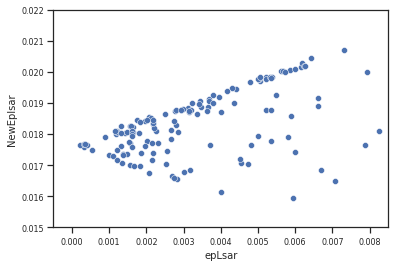

In [23]:
ax = sns.scatterplot(data=dfNewAvail,x='epLsar',y='NewEplsar');
ax.set_xlim(xrange);
ax.set_ylim(yrange);

Could be linear, but there is also a lot of noise.

Maybe different treatments have different behavior?

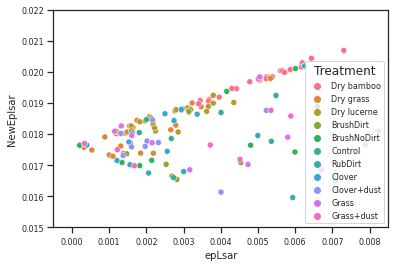

In [24]:
ax = sns.scatterplot(data=dfNewAvail,x='epLsar',y='NewEplsar',hue="Treatment");
ax.set_xlim(xrange);
ax.set_ylim(yrange);

Too crowded, let's try it per dataset

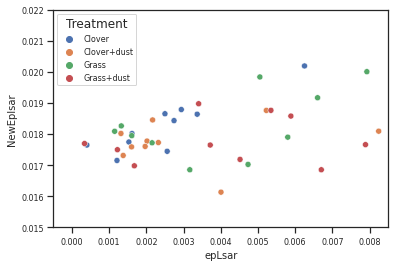

In [25]:
ax = sns.scatterplot(data=dfNewAvail[dfNewAvail.Dataset == "Sheeps"],x='epLsar',y='NewEplsar',hue="Treatment");
ax.set_xlim(xrange);
ax.set_ylim(yrange);

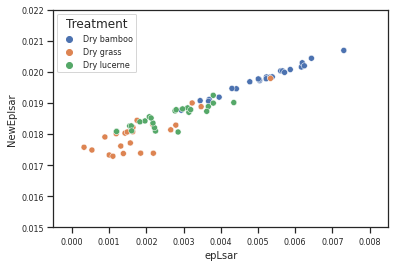

In [26]:
ax = sns.scatterplot(data=dfNewAvail[dfNewAvail.Dataset == "GuineaPigs"],x='epLsar',y='NewEplsar',hue="Treatment");
ax.set_xlim(xrange);
ax.set_ylim(yrange);

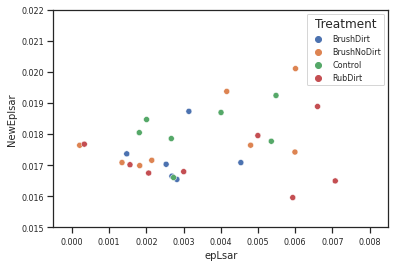

In [27]:
ax = sns.scatterplot(data=dfNewAvail[dfNewAvail.Dataset == "Lithics"],x='epLsar',y='NewEplsar',hue="Treatment");
ax.set_xlim(xrange);
ax.set_ylim(yrange);

### Standardization in z scores

In [28]:
dfNewAvail.NewEplsar

0      0.019460
2      0.020079
4      0.019722
6      0.020694
8      0.019841
         ...   
268    0.018765
270    0.018581
272    0.017697
274    0.018978
276    0.017498
Name: NewEplsar, Length: 139, dtype: float64

In [29]:
mu = dfNewAvail.NewEplsar.mean()
mu

0.018327855160863306

In [30]:
sig = dfNewAvail.NewEplsar.std()
sig

0.0010227435286363504

In [31]:
dictMeanStd['NewEplsar'] = (mu,sig)

In [32]:
newZ = (dfNewAvail.NewEplsar.values-mu) / sig

In [33]:
newIndex = df[~df.NewEplsar.isna()].index.values

## Model specification <a name="model"></a>

In [34]:
class Model_NewEplsar(pm.Model):
    
    """
    Compute params of priors and hyperpriors.
    """
    def getParams(self,x2,y):
        # get lengths        
        Nx2Lvl = np.unique(x2).size
        
        dims = (Nx2Lvl)
        
        ### get standard deviations
        
        # convert to pandas dataframe to use their logic
        df = pd.DataFrame.from_dict({'x2':x2,'y':y})
        
        s2 = df.groupby('x2').std()['y'].max()
        stdSingle = s2
        
        return (dims, stdSingle)
    
    def printParams(self,x2,y):
        dims, stdSingle= self.getParams(x2,y)
        Nx2Lvl = dims
        s2 = stdSingle
                
        print("The number of levels of the x variables are {}".format(dims))
        print("The standard deviations used for the beta prior is {}".format(stdSingle))        
    
    def __init__(self,name,x2,y,model=None):
        
        # call super's init first, passing model and name
        super().__init__(name, model)
        
        # get parameter of hyperpriors
        dims, stdSingle = self.getParams(x2,y)
        Nx2Lvl  = dims
        s2 = stdSingle
                
        ### hyperpriors ### 
        # observation hyperpriors
        lamY = 1/30.
        muGamma = 0.5
        sigmaGamma = 2.
        
        # prediction hyperpriors
        sigma0 = pm.HalfNormal('sigma0',sd=1)         
        sigma2 = pm.HalfNormal('sigma2',sd=s2, shape=Nx2Lvl)
        
        
        mu_b0 = pm.Normal('mu_b0', mu=0., sd=1)              
        mu_b2 = pm.Normal('mu_b2', mu=0., sd=1, shape=Nx2Lvl)       
        beta2 = 1.5*(np.sqrt(6)*sigma2)/(np.pi)
                                       
        ### priors ### 
        # observation priors        
        nuY = pm.Exponential('nuY',lam=lamY)
        sigmaY = pm.Gamma('sigmaY',mu=muGamma, sigma=sigmaGamma)
        
        # prediction priors
        b0_dist = pm.Normal('b0_dist', mu=0, sd=1)
        b0 = pm.Deterministic("b0", mu_b0 + b0_dist * sigma0)
                        
        b2_beta = pm.HalfNormal('b2_beta', sd=beta2, shape=Nx2Lvl)
        b2_dist = pm.Gumbel('b2_dist', mu=0, beta=1)
        b2 = pm.Deterministic("b2", mu_b2 + b2_beta * b2_dist)
        
        #### prediction ###         
        mu = pm.Deterministic('mu',b0 + b2[x2])
                                        
        ### observation ### 
        y = pm.StudentT('y',nu = nuY, mu=mu, sd=sigmaY, observed=y)

## Inference <a name="inference"></a>

### NewEplsar <a name="NewEplsar"></a>

In [35]:
with pm.Model() as model:
    new_epLsarModel = Model_NewEplsar('NewEplsar',x2[newIndex],newZ)

#### Verify model settings

In [36]:
new_epLsarModel.printParams(x2[newIndex],newZ)

The number of levels of the x variables are 11
The standard deviations used for the beta prior is 1.1366670418374532


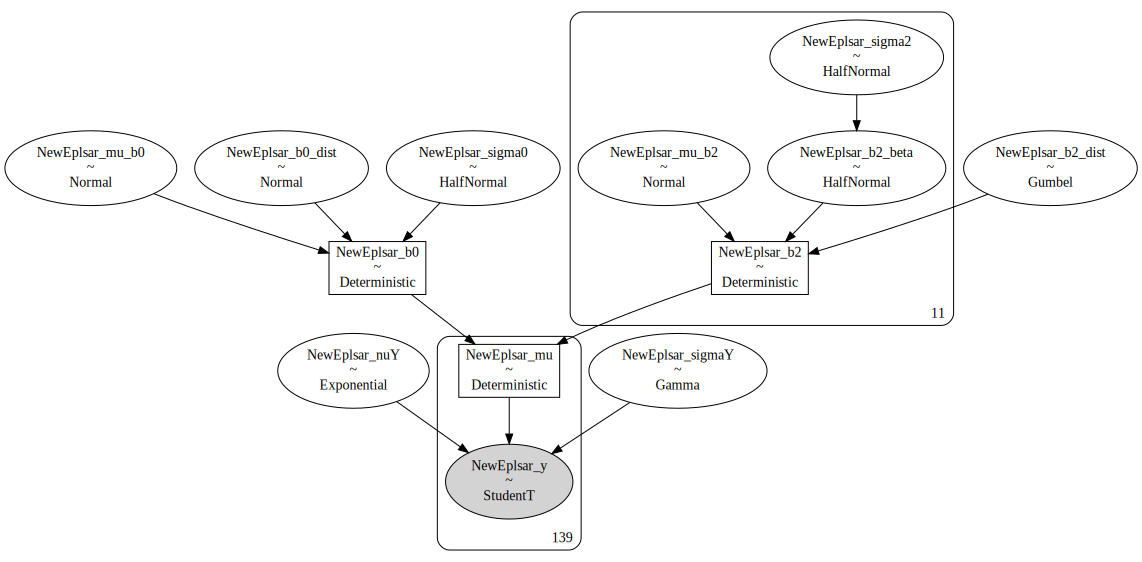

In [37]:
try:
    graph_new_epLsar = pm.model_to_graphviz(new_epLsarModel)    
except:
    graph_new_epLsar = "Could not make graph"
graph_new_epLsar

#### Check prior choice

In [38]:
with new_epLsarModel as model:
    prior_pred_new_epLsar = pm.sample_prior_predictive(samples=numPredSamples,random_seed=random_seed)

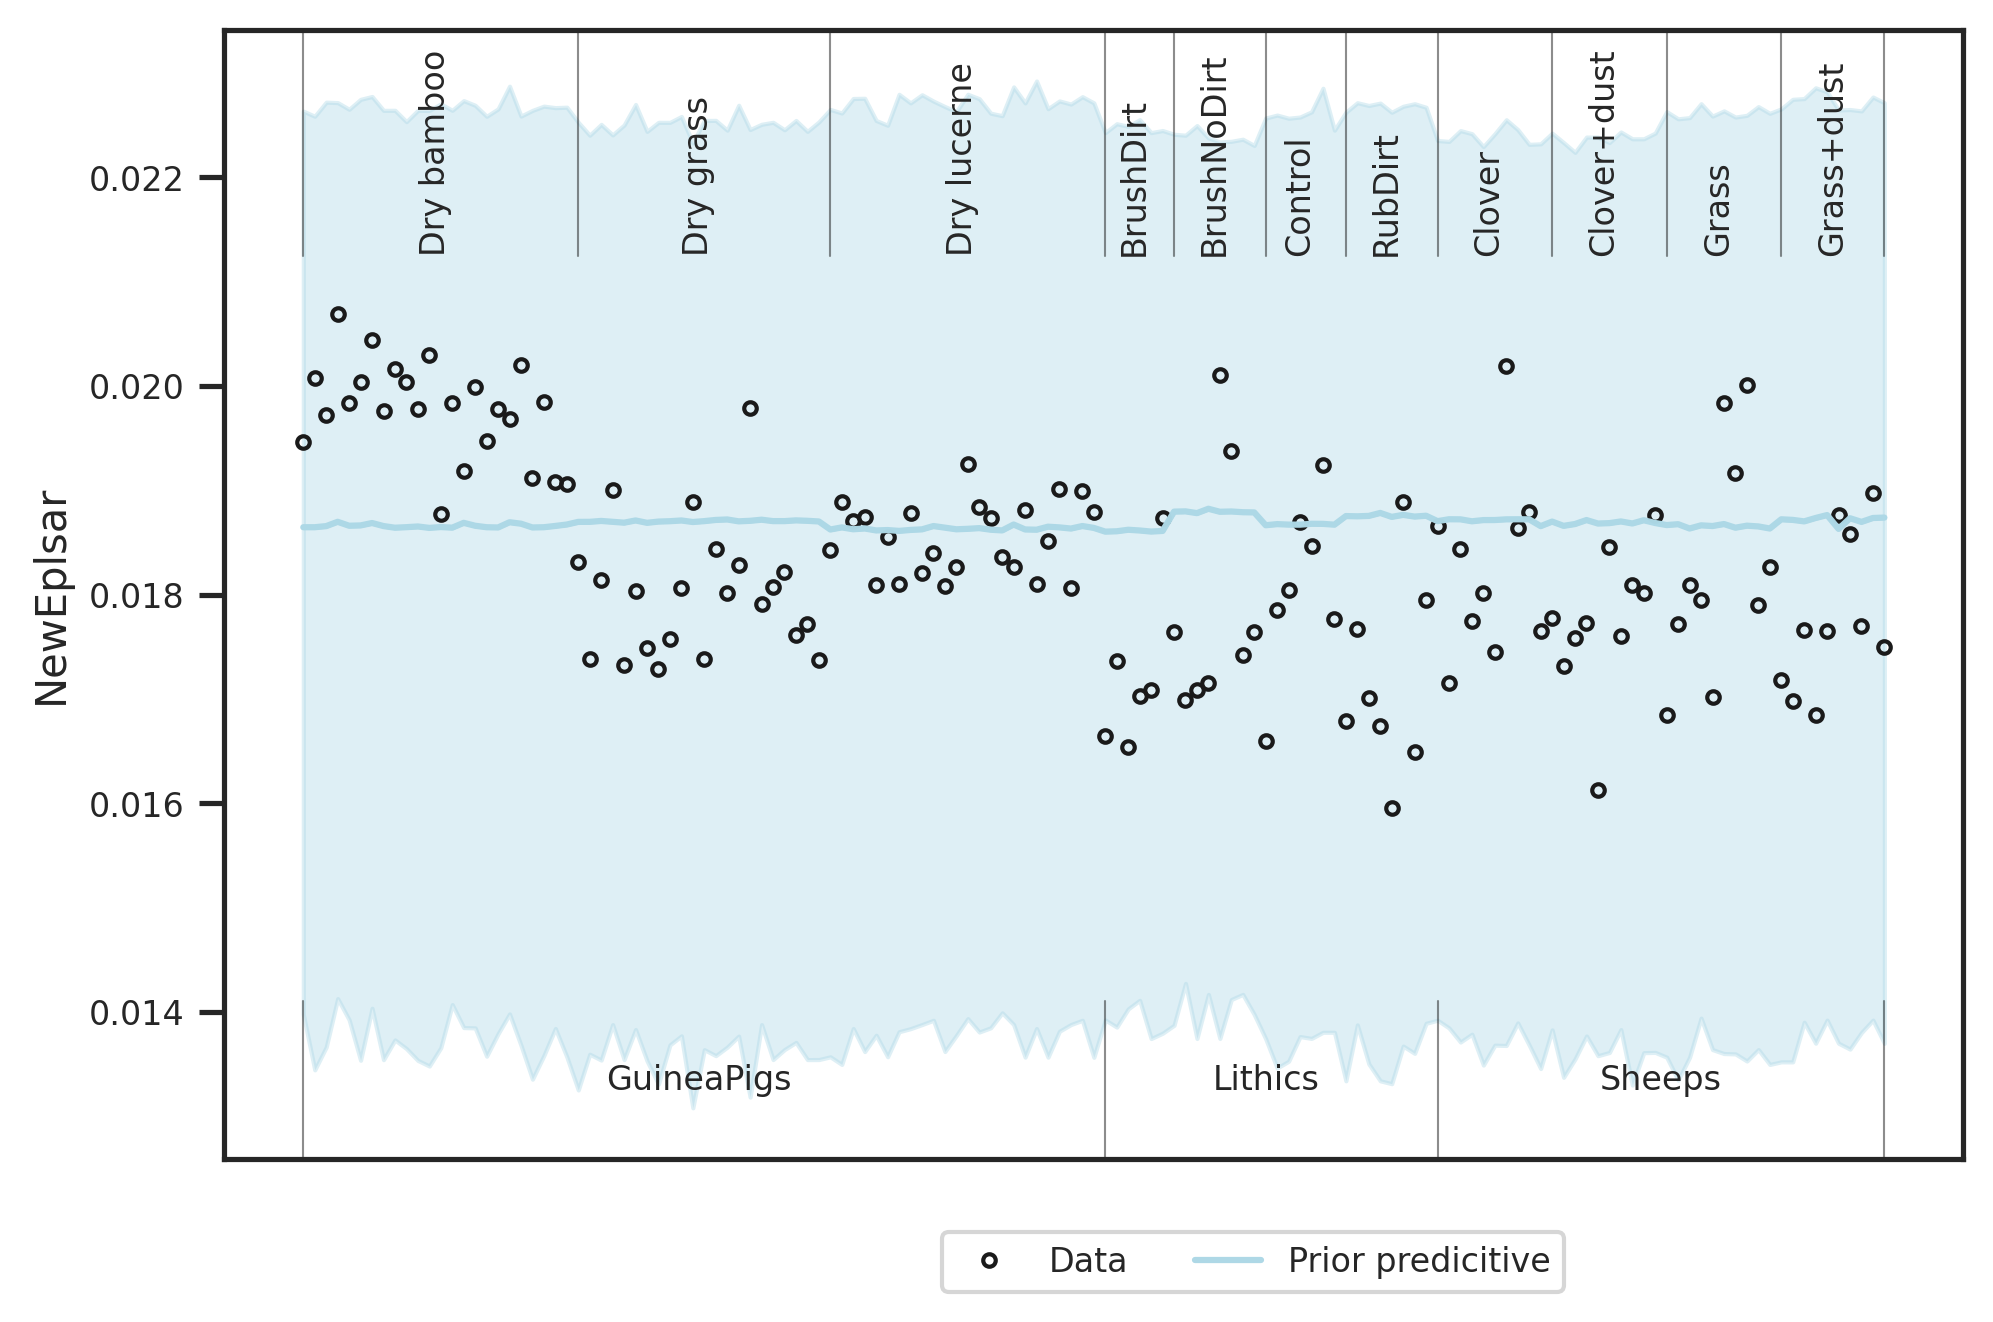

In [39]:
plotting_lib.plotPriorPredictive(widthInch,heigthInch,dpi,writeOut,outPathPlots,dfNewAvail.reset_index(),dictMeanStd,prior_pred_new_epLsar,newZ,'NewEplsar')

Prior choice is as intended: Broad over the data range.

#### Sampling

In [40]:
with new_epLsarModel as model:
    trace_new_epLsar = pm.sample(numSamples,cores=numCores,tune=numTune,max_treedepth=20, init='auto',target_accept=0.99,random_seed=random_seed)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [NewEplsar_b2_dist, NewEplsar_b2_beta, NewEplsar_b0_dist, NewEplsar_sigmaY, NewEplsar_nuY, NewEplsar_mu_b2, NewEplsar_mu_b0, NewEplsar_sigma2, NewEplsar_sigma0]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 66 seconds.
The number of effective samples is smaller than 10% for some parameters.


In [41]:
with new_epLsarModel as model:
    if writeOut:
        with open(outPathData + 'model_{}.pkl'.format('NewEplsar'), 'wb') as buff:
            pickle.dump({'model':new_epLsarModel, 'trace': trace_new_epLsar}, buff)

#### Check sampling

In [42]:
with new_epLsarModel as model:
    dataTrace_new_epLsar = az.from_pymc3(trace=trace_new_epLsar)

In [43]:
pm.summary(dataTrace_new_epLsar,hdi_prob=0.95).round(2)

mean    sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  \
NewEplsar_mu_b0    -0.25  0.64     -1.45       1.09       0.02     0.01   
NewEplsar_mu_b2[0] -0.77  0.49     -1.72       0.16       0.01     0.01   
NewEplsar_mu_b2[1] -0.36  0.46     -1.31       0.48       0.01     0.01   
NewEplsar_mu_b2[2]  0.13  0.46     -0.79       1.00       0.01     0.01   
NewEplsar_mu_b2[3] -0.19  0.45     -1.13       0.68       0.01     0.01   
...                  ...   ...       ...        ...        ...      ...   
NewEplsar_mu[134]  -0.59  0.22     -1.02      -0.16       0.00     0.00   
NewEplsar_mu[135]  -0.59  0.22     -1.02      -0.16       0.00     0.00   
NewEplsar_mu[136]  -0.59  0.22     -1.02      -0.16       0.00     0.00   
NewEplsar_mu[137]  -0.59  0.22     -1.02      -0.16       0.00     0.00   
NewEplsar_mu[138]  -0.59  0.22     -1.02      -0.16       0.00     0.00   

                    ess_mean  ess_sd  ess_bulk  ess_tail  r_hat  
NewEplsar_mu_b0       1816.0  1816.0    1794.0    2528.0    1.0  
NewEplsar_mu_b2[0]    1994.0  1994.0    2034.0    2364.0    1.0  
NewEplsar_mu_b2[1]    1787.0  1787.0    1786.0    2348.0    1.0  
NewEplsar_mu_b2[2]    1830.0  1830.0    1814.0    2326.0    1.0  
NewEplsar_mu_b2[3]    1674.0  1674.0    1687.0    2009.0    1.0  
...                      ...     ...       ...       ...    ...  
NewEplsar_mu[134]     4438.0  4264.0    4439.0    3252.0    1.0  
NewEplsar_mu[135]     4438.0  4264.0    4439.0    3252.0    1.0  
NewEplsar_mu[136]     4438.0  4264.0    4439.0    3252.0    1.0  
NewEplsar_mu[137]     4438.0  4264.0    4439.0    3252.0    1.0  
NewEplsar_mu[138]     4438.0  4264.0    4439.0    3252.0    1.0  

[190 rows x 11 columns]

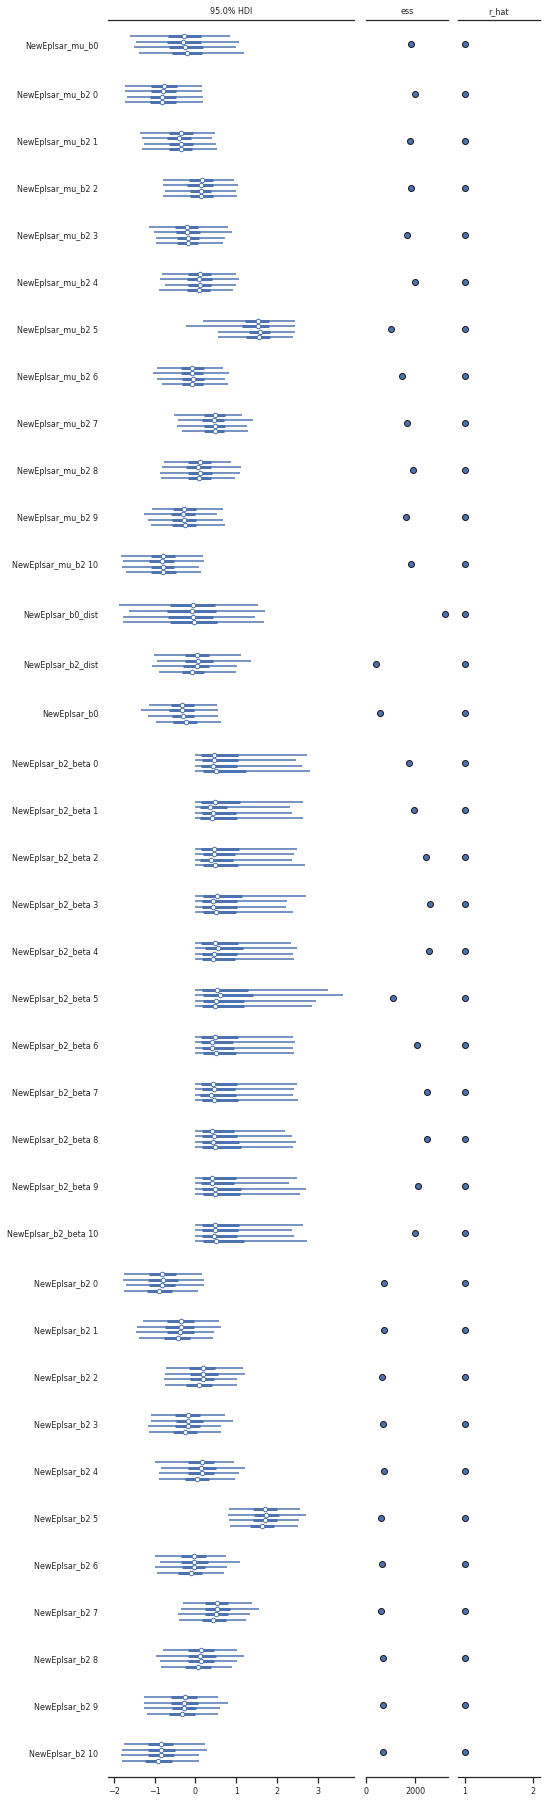

In [44]:
az.plot_forest(dataTrace_new_epLsar,var_names=['b0','b2'],filter_vars='like',figsize=(widthInch,5*heigthInch),hdi_prob=0.95,ess=True,r_hat=True);
if writeOut:
    plt.savefig(outPathPlots + "posterior_forest_{}.pdf".format('NewEplsar'),dpi=dpi)

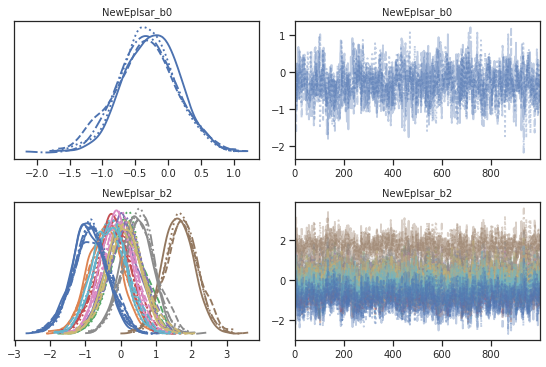

In [45]:
with new_epLsarModel as model:
    plotting_lib.plotTracesB(widthInch,heigthInch,dpi,writeOut,outPathPlots,trace_new_epLsar,'NewEplsar')

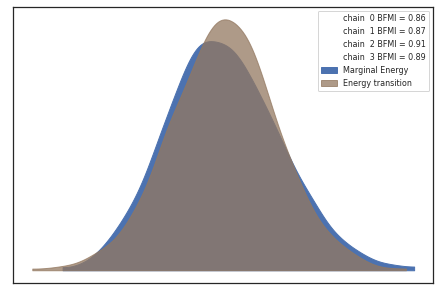

In [46]:
with new_epLsarModel as model:
    plotting_lib.pm.energyplot(trace_new_epLsar)

#### Posterior predictive distribution

In [47]:
with new_epLsarModel as model:
    posterior_pred_new_epLsar = pm.sample_posterior_predictive(trace_new_epLsar,samples=numPredSamples,random_seed=random_seed)

/home/bob/Documents/Projekt_Neuwied/SSFA/ssfa-env/lib/python3.7/site-packages/pymc3/sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


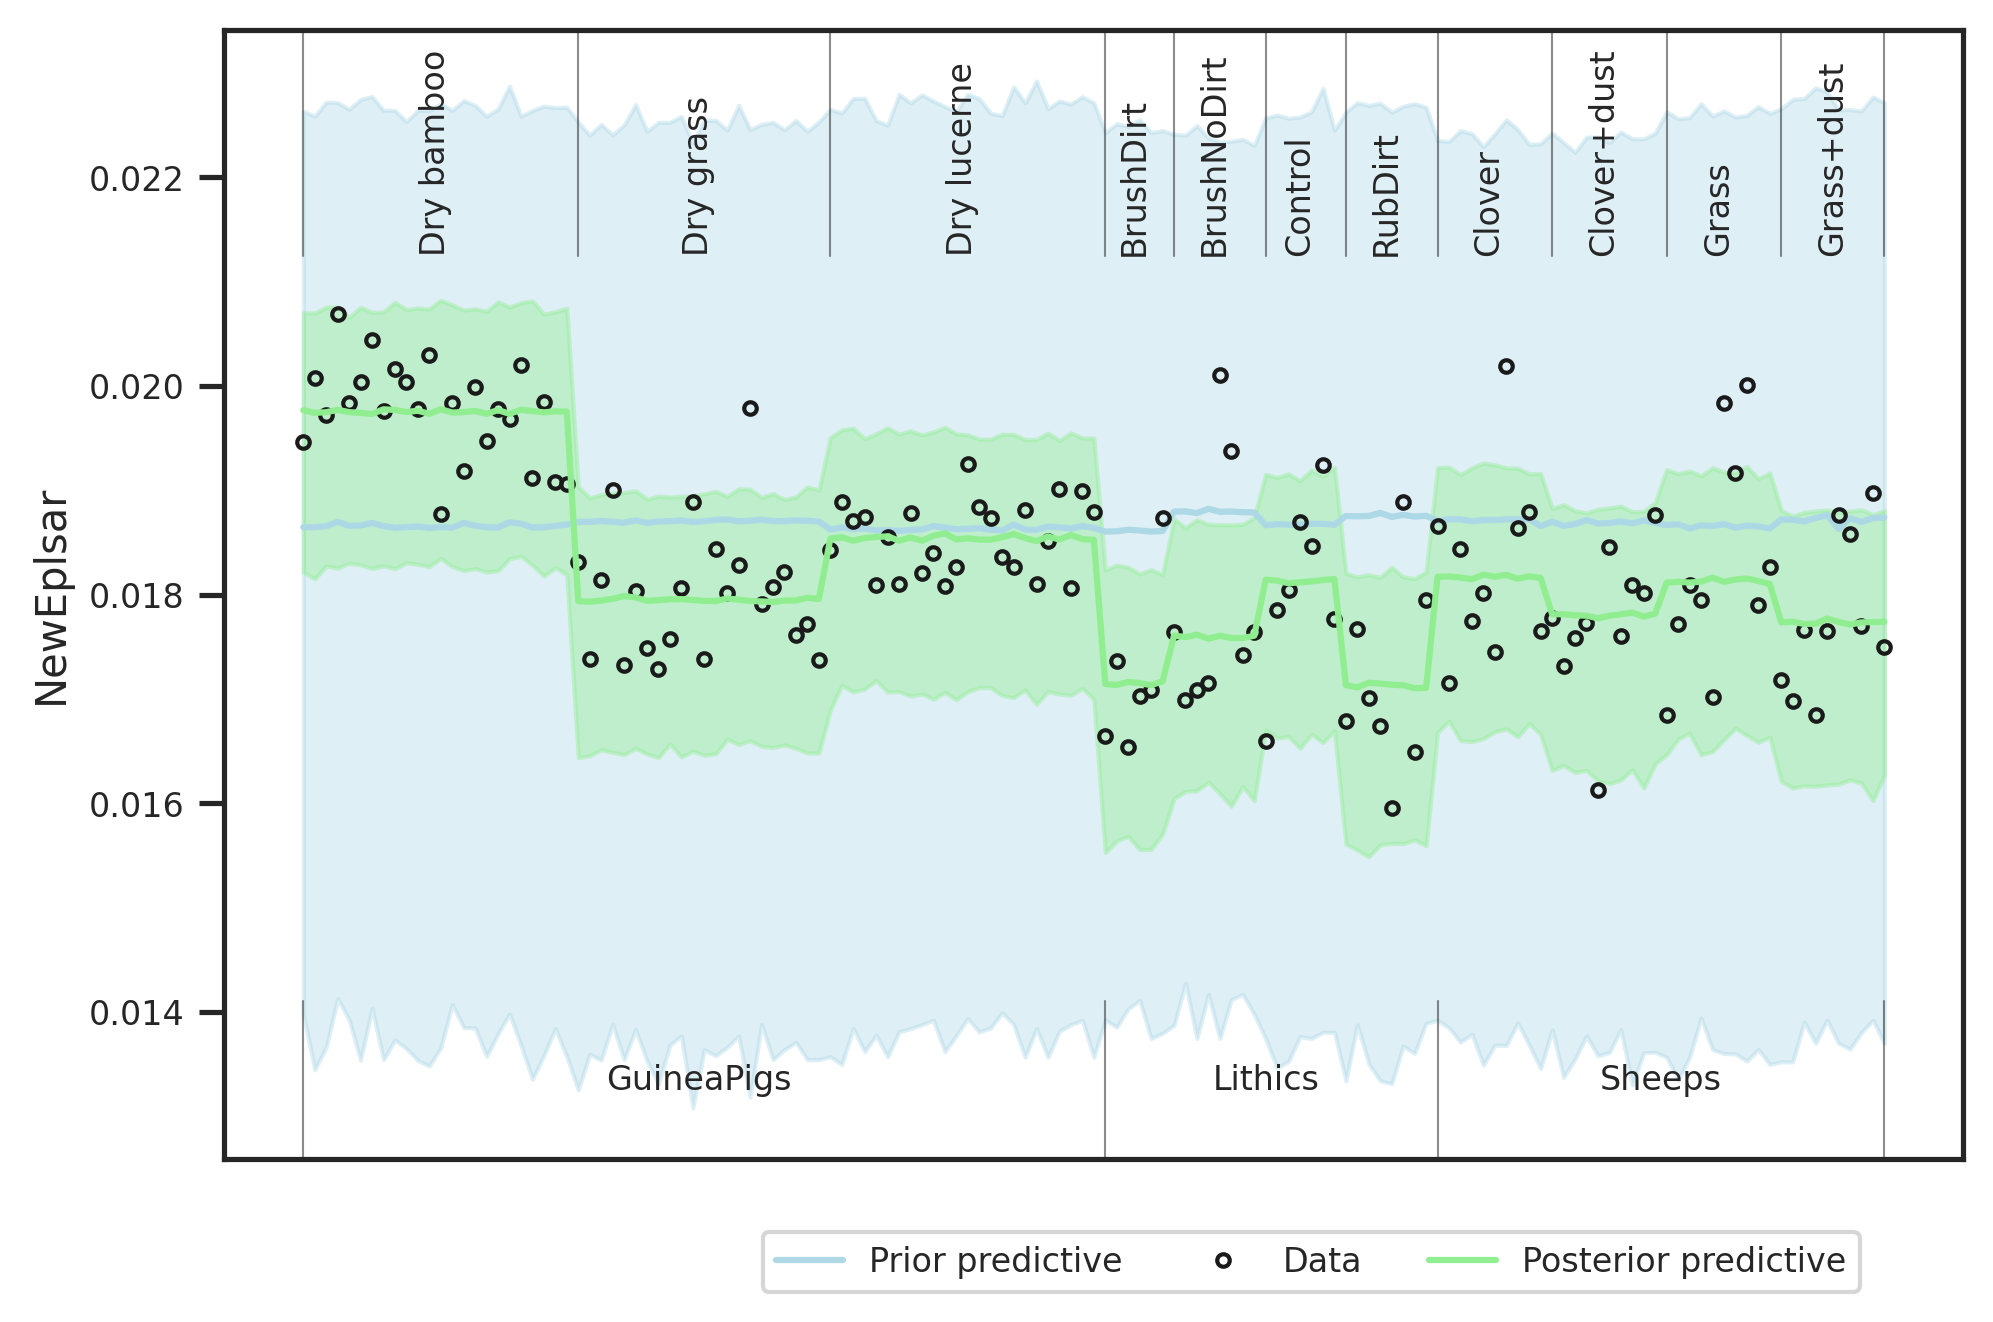

In [48]:
plotting_lib.plotPriorPosteriorPredictive(widthInch,heigthInch,dpi,writeOut,outPathPlots,dfNewAvail.reset_index(),dictMeanStd,prior_pred_new_epLsar,posterior_pred_new_epLsar,newZ,'NewEplsar')

### Posterior check

In [49]:
with new_epLsarModel as model:
    pm_data_new_epLsar = az.from_pymc3(trace=trace_new_epLsar,prior=prior_pred_new_epLsar,posterior_predictive=posterior_pred_new_epLsar)

arviz.data.io_pymc3 - WARNING - posterior predictive variable NewEplsar_y's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


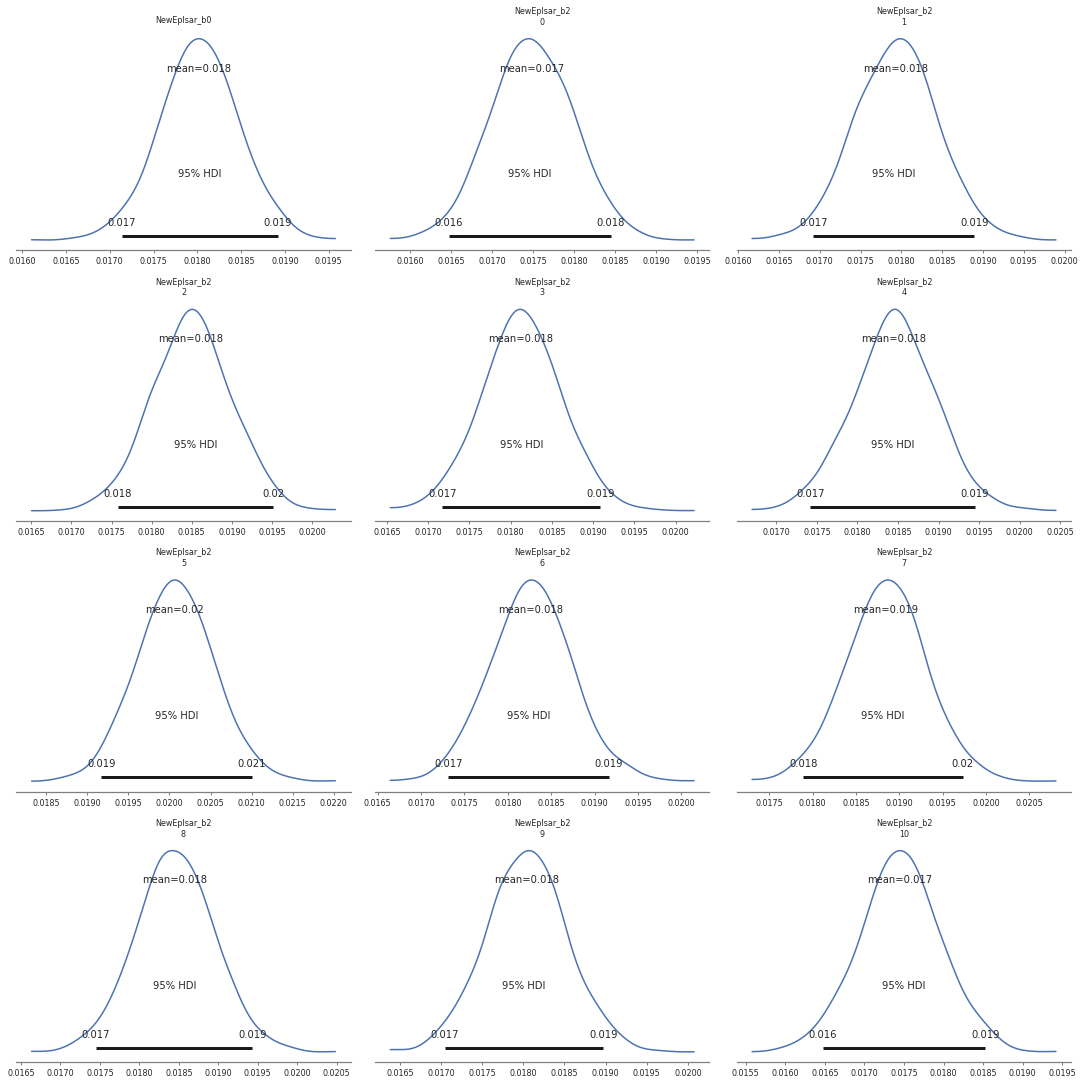

In [50]:
plotting_lib.plotPosterior(widthInch,heigthInch,dpi,writeOut,outPathPlots,dictMeanStd,pm_data_new_epLsar,'NewEplsar')

### Compare treatment differences with other epLsar values

In [51]:
b1P_Old = np.load("../derived_data/statistical_model_two_factors_filter_weak/epLsar_oldb1.npy")
b2P_Old = np.load("../derived_data/statistical_model_two_factors_filter_weak/epLsar_oldb2.npy")
M12P_Old = np.load("../derived_data/statistical_model_two_factors_filter_weak/epLsar_oldM12.npy")

In [52]:
from collections import defaultdict 

In [53]:
def plotTreatmentPosterior(widthInch,heigthInch,dpi,sizes,writeOut,path,dictMeanStd,dictTreatment,dictSoftware,trace,yname,x1,x3):
        
    SMALL_SIZE,MEDIUM_SIZE,BIGGER_SIZE = sizes
    
    mu_Val,sig_Val = dictMeanStd[yname]
    
    # get posterior samples    
    b2P = sig_Val*trace['{}_b2'.format(yname)]
    
    # prepare color dict for treatments
    # use groups of 4 colors, as in tab20c
    colorIndex = dict({5:0,6:1,7:2,0:4,1:5,4:6,10:7,2:8,3:9,8:10,9:11})
    
    # prepare dataset dict for treatments   
    dictDataset = dict({5:0,6:0,7:0,0:1,1:1,4:1,10:1,2:2,3:2,8:2,9:2})
    
    # === inverse dict ==== 
    inv_dictDataset = defaultdict(list)                                                                  
  
    # using loop to perform reverse mapping 
    for keys, vals in dictDataset.items():  
        for val in [vals]:  
            inv_dictDataset[val].append(keys) 
    # === 
    
    # get number of datasets    
    numDatasets = len(np.unique(list(dictDataset.values())))
    
    # get number of treatments per dataset
    dictDataset2NumberTreats = dict()
    for numDataset in range(numDatasets):        
        n = len(inv_dictDataset[numDataset])
        dictDataset2NumberTreats[numDataset] = n      
         
    # Get maximum of treatments per dataset
    tmax = np.max(list(dictDataset2NumberTreats.values()))
    
    
    # compute maximal number of pairs 
    maxpair = int(tmax*(tmax-1)/2)
    
    
    fig = plt.subplots(squeeze=False, figsize=(numDatasets*widthInch,maxpair*heigthInch), dpi=dpi);
    
    # store list for hdi
    hdiList = []

    for indexDataset in np.arange(numDatasets):
        # counter for row
        rowCounter = 0
        
        # first treatment 
        for treatmentNum_i,lvl2_i in enumerate(inv_dictDataset[indexDataset]):
            
            # second treatment 
            for treatmentNum_j,lvl2_j in enumerate(inv_dictDataset[indexDataset]):
                
                if treatmentNum_i > treatmentNum_j:
                                       
                    
                    # set subplot                    
                    curr_ax = plt.subplot2grid((maxpair, numDatasets), (rowCounter,indexDataset))
  
                    # compute difference between treatments for each software
                    diffS0 = sig_Val*((M12P_Old[:,0,lvl2_i]+b2P_Old[:,lvl2_i]) -(M12P_Old[:,0,lvl2_j]+b2P_Old[:,lvl2_j]))
                    diffS1 = sig_Val*((M12P_Old[:,1,lvl2_i]+b2P_Old[:,lvl2_i]) -(M12P_Old[:,1,lvl2_j]+b2P_Old[:,lvl2_j]))
                    
                    #plot posterior                    
                    sns.kdeplot(diffS1,ax=curr_ax,label="epLsar on {}".format(dictSoftware[1]),color='gray',alpha=0.3,ls='--');
                    sns.kdeplot(diffS0,ax=curr_ax,label="epLsar on {}".format(dictSoftware[0]),color='gray',alpha=0.3,ls='dotted');                    
                    sns.kdeplot(b2P[:,lvl2_i]-b2P[:,lvl2_j],ax=curr_ax,label="NewEplsar on {}".format(dictSoftware[0]),color='C0',alpha=0.3,ls='dotted');
                                        
                    # plot reference value zero
                    curr_ax.axvline(x=0,color="C1")
                    
                    # get hdi
                    hdi_new = az.hdi(az.convert_to_inference_data(b2P[:,lvl2_i]-b2P[:,lvl2_j]),hdi_prob=0.95)['x'].values
                    hdiS0 = az.hdi(az.convert_to_inference_data(diffS0),hdi_prob=0.95)['x'].values
                    hdiS1 = az.hdi(az.convert_to_inference_data(diffS1),hdi_prob=0.95)['x'].values  
                    
                    isSignificant = lambda x: (x[0] > 0.0) or (x[1] < 0.0)
                    
                    # store hdi
                    hdiList.append([dictTreatment[lvl2_i],dictTreatment[lvl2_j],
                                    hdi_new[0],hdi_new[1],isSignificant(hdi_new),                                 
                                   hdiS0[0],hdiS0[1],isSignificant(hdiS0),
                                    hdiS1[0],hdiS1[1],isSignificant(hdiS1)
                                   ])
                    
                    # set title 
                    nameFirst = dictTreatment[lvl2_i]
                    nameSecond = dictTreatment[lvl2_j]
                    title = "{} vs. {}".format(nameFirst,nameSecond)
                    if isSignificant(hdi_new):
                        title += ": Significant on NewEplsar"

                            
                    curr_ax.set_title(title)
                    
                    # add legend
                    curr_ax.legend()   
                    
                    # set x label
                    curr_ax.set_xlabel('Delta')
                    
                    # remove y label decoration
                    curr_ax.tick_params(left=False)
                    curr_ax.set(yticklabels=[])
                    
                    
                    # increment counter
                    rowCounter += 1
                    
    #plt.suptitle('Estimated differences between treatments on {}'.format(yname))
    
    plt.tight_layout()                
    
    if writeOut:
        plt.savefig(path + "treatment_pairs_{}.pdf".format(yname),dpi=dpi)
    
    plt.show()
    
    # convert hdi to df
    df = pd.DataFrame(hdiList,columns=["Treatment_i","Treatment_j",
                                       "hdi_NewEplsar_2.5%","hdi_NewEplsar_97.5%","isSignificant_NewEplsar","hdi_{}_2.5%".format(dictSoftware[0]),"hdi_{}_97.5%".format(dictSoftware[0]),"isSignificant_on_{}".format(dictSoftware[0]),
                                  "hdi_{}_2.5%".format(dictSoftware[1]),"hdi_{}_97.5%".format(dictSoftware[1]),"isSignificant_on_{}".format(dictSoftware[1])])
    return df

In [54]:
dfHDI = plotTreatmentPosterior(widthInch,heigthInch,dpi,sizes,writeOut,outPathPlots,dictMeanStd,dictTreatment,dictSoftware,trace_new_epLsar,'NewEplsar',x1[newIndex],x2[newIndex])

In [55]:
dfHDI

Treatment_i  Treatment_j  hdi_NewEplsar_2.5%  hdi_NewEplsar_97.5%  \
0     Dry grass   Dry bamboo           -0.002178            -0.001432   
1   Dry lucerne   Dry bamboo           -0.001583            -0.000877   
2   Dry lucerne    Dry grass            0.000157             0.000910   
3   BrushNoDirt    BrushDirt           -0.000292             0.001164   
4       Control    BrushDirt            0.000253             0.001714   
5       Control  BrushNoDirt           -0.000210             0.001274   
6       RubDirt    BrushDirt           -0.000763             0.000687   
7       RubDirt  BrushNoDirt           -0.001225             0.000242   
8       RubDirt      Control           -0.001713            -0.000264   
9   Clover+dust       Clover           -0.000923             0.000248   
10        Grass       Clover           -0.000696             0.000588   
11        Grass  Clover+dust           -0.000310             0.000979   
12   Grass+dust       Clover           -0.001042             0.000196   
13   Grass+dust  Clover+dust           -0.000685             0.000490   
14   Grass+dust        Grass           -0.001022             0.000228   

    isSignificant_NewEplsar  hdi_ConfoMap_2.5%  hdi_ConfoMap_97.5%  \
0                      True          -0.002191           -0.001369   
1                      True          -0.001755           -0.000944   
2                      True           0.000030            0.000829   
3                     False          -0.000727            0.001097   
4                      True          -0.000555            0.001088   
5                     False          -0.000899            0.001002   
6                     False          -0.000378            0.001560   
7                     False          -0.000735            0.001439   
8                      True          -0.000707            0.001324   
9                     False          -0.000593            0.000735   
10                    False           0.000027            0.001602   
11                    False          -0.000121            0.001507   
12                    False           0.000175            0.001740   
13                    False           0.000088            0.001711   
14                    False          -0.000754            0.001056   

    isSignificant_on_ConfoMap  hdi_Toothfrax_2.5%  hdi_Toothfrax_97.5%  \
0                        True           -0.002109            -0.001265   
1                        True           -0.001852            -0.001067   
2                        True           -0.000170             0.000652   
3                       False           -0.000948             0.000677   
4                       False           -0.000342             0.001413   
5                       False           -0.000316             0.001475   
6                       False           -0.000888             0.000746   
7                       False           -0.000700             0.000890   
8                       False           -0.001397             0.000348   
9                       False           -0.000486             0.000896   
10                       True            0.000204             0.001960   
11                      False            0.000026             0.001754   
12                       True            0.000327             0.001812   
13                       True            0.000150             0.001657   
14                      False           -0.000896             0.000879   

    isSignificant_on_Toothfrax  
0                         True  
1                         True  
2                        False  
3                        False  
4                        False  
5                        False  
6                        False  
7                        False  
8                        False  
9                        False  
10                        True  
11                        True  
12                        True  
13                        True  
14                       False

In [56]:
if writeOut:
    dfHDI.to_csv(outPathData+ 'hdi_{}_filter_weak.csv'.format('NewEplsar'))

## Summary<a name="summary"></a>

Show where NewEplsar yields other results then epLsar: 

In [57]:
df_summary = dfHDI[(dfHDI.isSignificant_NewEplsar != dfHDI.isSignificant_on_ConfoMap) | (dfHDI.isSignificant_NewEplsar != dfHDI.isSignificant_on_Toothfrax) ][["Treatment_i","Treatment_j","isSignificant_NewEplsar","isSignificant_on_Toothfrax","isSignificant_on_ConfoMap","hdi_NewEplsar_2.5%","hdi_NewEplsar_97.5%","hdi_ConfoMap_2.5%","hdi_ConfoMap_97.5%","hdi_Toothfrax_2.5%","hdi_Toothfrax_97.5%"]]
df_summary

Treatment_i  Treatment_j  isSignificant_NewEplsar  \
2   Dry lucerne    Dry grass                     True   
4       Control    BrushDirt                     True   
8       RubDirt      Control                     True   
10        Grass       Clover                    False   
11        Grass  Clover+dust                    False   
12   Grass+dust       Clover                    False   
13   Grass+dust  Clover+dust                    False   

    isSignificant_on_Toothfrax  isSignificant_on_ConfoMap  hdi_NewEplsar_2.5%  \
2                        False                       True            0.000157   
4                        False                      False            0.000253   
8                        False                      False           -0.001713   
10                        True                       True           -0.000696   
11                        True                      False           -0.000310   
12                        True                       True           -0.001042   
13                        True                       True           -0.000685   

    hdi_NewEplsar_97.5%  hdi_ConfoMap_2.5%  hdi_ConfoMap_97.5%  \
2              0.000910           0.000030            0.000829   
4              0.001714          -0.000555            0.001088   
8             -0.000264          -0.000707            0.001324   
10             0.000588           0.000027            0.001602   
11             0.000979          -0.000121            0.001507   
12             0.000196           0.000175            0.001740   
13             0.000490           0.000088            0.001711   

    hdi_Toothfrax_2.5%  hdi_Toothfrax_97.5%  
2            -0.000170             0.000652  
4            -0.000342             0.001413  
8            -0.001397             0.000348  
10            0.000204             0.001960  
11            0.000026             0.001754  
12            0.000327             0.001812  
13            0.000150             0.001657

In [58]:
if writeOut:
    df_summary.to_csv(outPathData+ 'summary_filter_weak.csv')

### Write out

In [61]:
!jupyter nbconvert --to html Statistical_Model_NewEplsar_filter_weak.ipynb

[NbConvertApp] Converting notebook Statistical_Model_NewEplsar_filter_weak.ipynb to html
[NbConvertApp] Writing 4867803 bytes to Statistical_Model_NewEplsar_filter_weak.html


In [62]:
!jupyter nbconvert --to markdown Statistical_Model_NewEplsar_filter_weak.ipynb

[NbConvertApp] Converting notebook Statistical_Model_NewEplsar_filter_weak.ipynb to markdown
[NbConvertApp] Support files will be in Statistical_Model_NewEplsar_filter_weak_files/
[NbConvertApp] Making directory Statistical_Model_NewEplsar_filter_weak_files
[NbConvertApp] Making directory Statistical_Model_NewEplsar_filter_weak_files
[NbConvertApp] Making directory Statistical_Model_NewEplsar_filter_weak_files
[NbConvertApp] Making directory Statistical_Model_NewEplsar_filter_weak_files
[NbConvertApp] Making directory Statistical_Model_NewEplsar_filter_weak_files
[NbConvertApp] Making directory Statistical_Model_NewEplsar_filter_weak_files
[NbConvertApp] Making directory Statistical_Model_NewEplsar_filter_weak_files
[NbConvertApp] Making directory Statistical_Model_NewEplsar_filter_weak_files
[NbConvertApp] Making directory Statistical_Model_NewEplsar_filter_weak_files
[NbConvertApp] Making directory Statistical_Model_NewEplsar_filter_weak_files
[NbConvertApp] Making directory Statisti